In [40]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
from sklearn import metrics

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 7.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload





# Exploring k-Means Clustering

In this problem, we will gain some experience with k-Means clustering.  The k-Means algorithm is relatively simple, wherein the user specifies a number of target clusters to be made and provides an initial seed position for the clusters.  Then, clusters are formed iteratively by (1) associating each object to the nearest cluster center and (2) updating the cluster center by evaluating the average position in each dimension from the objects associated with the cluster.

Rather than build your own clustering algorithm, we will explore the use of the k-Means clustering algorithm implemented in ```sci-kit learn```.  We will also use several of the tools provided by ```scikit-learn``` to help gain experience with how useful they are.  In particular, we will rely on metrics to help us gauge the quality and reliability of the clustering results:

1. Adjusted Rand Index wherein larger values indicate better clustering results.  Can only use this if we have the truth labels.
1. Silhouette Score wherein larger values indicate better clustering results.
1. Davies-Bouldin Score wherein lower values indicate better clustering results.

There will be two parts to this problem:

  1. Explore a simple N-cluster problem with four primary configurable parameters;
  2. Use your experience with basic clustering to tackle a more challenging "real world" data set;


# Part 1:  k-Means Clustering of Gaussian Data

In this part, you're provided an example of how to make a Gaussian cluster dataset where the number of clusters and their standard deviations are provided by the user.  You're also provided an example of how to set up the scikit-learn k-Means algorithm.


## Part 1a: Getting comfortable with k-Means

Your task is to run K-means several times but varying the following: 
- `n_trueClusters` (the true number of clusters to be generated)
- `std_dev` (spatial size of the clusters) 
- `n_points` (the number of data points in the clusters) 
- `n_kmClusters` (the number of clusters to be created by the k-Means algorithm) 

***
***

### Part 1a: Questions to answer
1. As the cluster compactness rises, what happens to the minimum cost (inertia) found by k-means? 
1. How do your qualitative evaluations of the clusters found vary as the number of true clusters vary? 
1. How does the minimum cost depend on the number of points in the clusters?
1. Do you observe similar trends with the other metrics (adjusted rand index, silhouette score and Davies-Bouldin Score)?

### Part 1a: Answers

#### 1. As the cluster compactness rises, what happens to the minimum cost (inertia) found by k-means?
- As cluster compactness increases (i.e., clusters become more tightly packed, `std_dev` decreases), the minimum cost (inertia) **decreases**.
- This happens because points are closer to their respective cluster centers, reducing intra-cluster variance.
- Conversely, when clusters are more spread out (`std_dev` increases), inertia increases because points are farther from their assigned cluster centers.

#### 2. How do your qualitative evaluations of the clusters found vary as the number of true clusters vary?
- When `n_kmClusters` matches `n_trueClusters`, k-Means identifies clusters accurately.
- Qualitative Observations when `n_kmClusters` matches `n_trueClusters`:
1. Clusters are well-defined and compact.
2. Each true cluster is correctly assigned to a K-means cluster.
3. Minimal overlap between different clusters.
   
- If `n_kmClusters` is **less than** `n_trueClusters`, k-Means merges some natural clusters, leading to **oversimplification**.
- Qualitative Observations when `n_kmClusters` is **less than** `n_trueClusters`:
1. Some clusters are unnecessarily small.
2. Natural groupings get split into multiple artificial clusters.
3. K-means overfits the data, finding structure where none exists.
   
- If `n_kmClusters` is **greater than** `n_trueClusters`, k-Means **over-segments** the data, splitting natural clusters into multiple smaller groups.
- Qualitative Observations when `n_kmClusters` is **greater than** `n_trueClusters`:
1. Some clusters contain widely spread points.
2. Cluster boundaries are poorly defined.
3. K-means struggles to separate distinct groups.

- The quality of clustering depends on the correct selection of `n_kmClusters` relative to `n_trueClusters`.

#### 3. How does the minimum cost depend on the number of points in the clusters?
- As the number of points (`n_points`) increases, **the inertia also increases** because k-Means minimizes the sum of squared distances from points to their assigned cluster centers.
- More points lead to a higher total sum of squared errors, even if the per-point clustering quality remains the same.
- However, the overall cluster structure remains stable unless the dataset becomes too large, making convergence slower.

#### 4. Do you observe similar trends with the other metrics (adjusted rand index, silhouette score, and Davies-Bouldin Score)?
- **Silhouette Score** (higher is better): Decreases when clusters overlap (high `std_dev`), increases when clusters are well-separated and compact (low `std_dev`).
- **Davies-Bouldin Score** (lower is better): Increases when clusters are too spread out, decreases when clusters are compact and well-separated.
- **Adjusted Rand Index** (higher is better, needs true labels): High when `n_kmClusters` closely matches `n_trueClusters`. Drops when k-Means merges or over-segments clusters.


___
### First let's define some useful functions
---

In [26]:
#Plotting function
def plot_clusters(labels, clusters, X,iteration=0,idx1=0,idx2=1,xlabel="X",ylabel="Y"):
    unique_labels = set(labels)
    colors = cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        plt.plot(xy[:, idx1], xy[:, idx2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=5, alpha=0.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.plot(clusters[k,idx1],clusters[k,idx2],'o',markerfacecolor=col,
             markeredgecolor='k', markersize=20,alpha=0.8)
    plt.title('Clustering: Iteration %d'%(iteration))  

# Convenient way of getting metrics
def rank_clusters(X,labels,truth_labels=[],verbose=True):
    retval = np.zeros(2)
    retval[0] = metrics.silhouette_score(X,labels) #larger is better!
    retval[1] = metrics.davies_bouldin_score(X,labels) #lower is better!
    if len(truth_labels) > 0:
        retval2 = np.zeros(3)
        retval2[[0,1]] = retval
        retval2[2] = metrics.adjusted_rand_score(truth_labels, labels) #larger is better!
        retval = retval2

    if verbose:
        print("Silhouette Score: ",retval[0])
        print("Davies-Bouldin Score: ",retval[1])
        if len(truth_labels) > 0:
            print("Adjusted Rand: ", retval[2]) 
    return retval 

___
### Generate Data
---

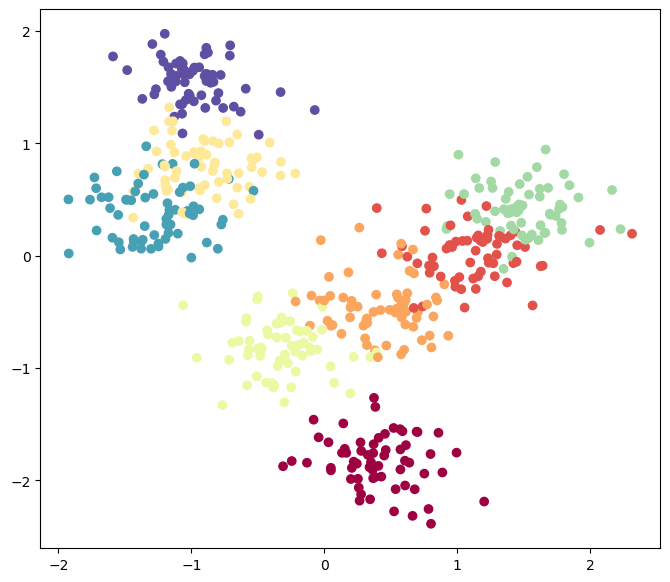

In [30]:
#Set cluster standard deviation and cluster number
std_dev= 1
n_trueClusters = 8
n_dim = 2  #you can do this in N-D, but let's use 2D for easy viewing
n_points = 500
randState = 2

# Generate sample data
X, labels_true = make_blobs(centers=n_trueClusters,n_samples=n_points, 
                            n_features=n_dim, cluster_std=std_dev,random_state=randState)

# Perform standard scaling on the full set of clusters
X = StandardScaler().fit_transform(X)

#plot the data as a sanity check!
fig = plt.figure()
plt.scatter(X[:,0],X[:,1],c=labels_true,cmap=cm.Spectral)
plt.show() 

***
### Now let's let k-Means find the clusters!!

We need to the number of clusters we want the algorithm to seed and we're off to the races.
***

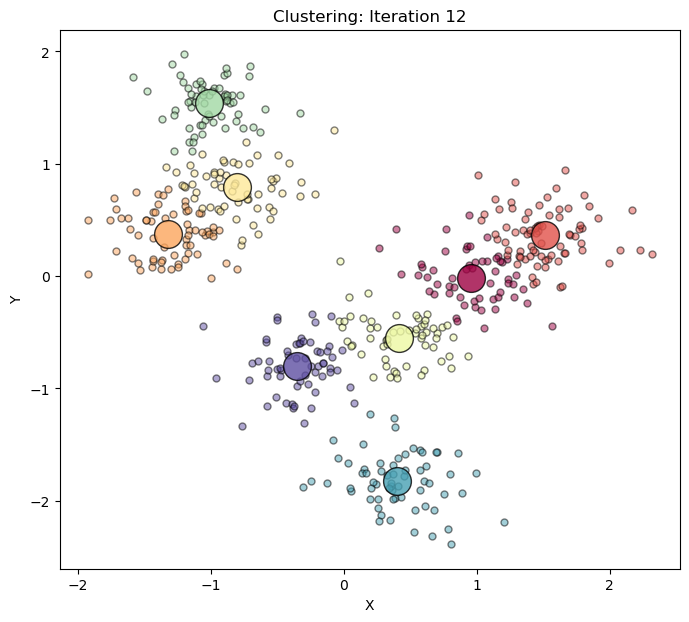

KM final cost:
 56.15453533004978
KM cluster centers:
 [[ 0.9560928  -0.01336677]
 [ 1.51102381  0.36332864]
 [-1.31873495  0.37006307]
 [-0.80490619  0.79467294]
 [ 0.4169037  -0.54866428]
 [-1.01198896  1.53979767]
 [ 0.40266344 -1.82400822]
 [-0.35428637 -0.79951399]]
Silhouette Score:  0.44520296707855206
Davies-Bouldin Score:  0.798652693814061
Adjusted Rand:  0.7292215960671659


array([0.44520297, 0.79865269, 0.7292216 ])

In [31]:
#First set up your parameters
n_kmClusters=8 #Set Number of Clusters

# Initialize KMeans and plot the results
km = KMeans(n_clusters=n_kmClusters,init="random")
km.fit(X)
labels = km.predict(X)

fig = plt.figure()
plot_clusters(labels,km.cluster_centers_,X,km.n_iter_)
plt.show()

#report from the k-Means results
print("KM final cost:\n",km.inertia_)
print("KM cluster centers:\n",km.cluster_centers_)

# evaluate three useful metrics
rank_clusters(X,labels,truth_labels = labels_true) 

***
## Part 1b: Elbow plot
Once you have some experience with the clustering, set `std_dev=1.0`, `n_samples=500`,  and `n_trueClusters=6`.  Use the elbow method to choose the "best" value of `n_kmClusters` and report your findings.  Explain why you made this choice.  Elbow plots are usually made using the "loss" function being minimized, which is the inertial for k-Means.  But you will also find it instructive to also plot the Adjusted Rand Index (ARI), Silhouette Score and Davies-Bouldin Score.  Note that the ARI requires the truth labels and the assigned cluster labels, so this can only be evaluated with a labeled dataset.

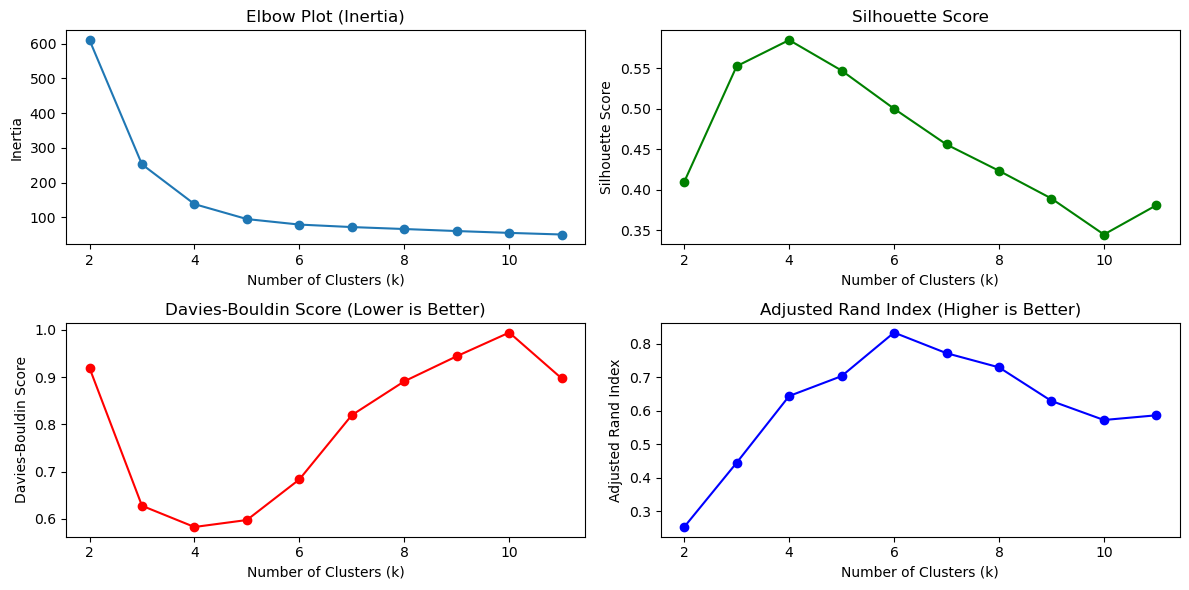

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# Set parameters
std_dev = 1.0
n_samples = 500
n_trueClusters = 6
n_dim = 2  # 2D for visualization
randState = 2

# Generate sample data
X, labels_true = make_blobs(centers=n_trueClusters, n_samples=n_samples, 
                            n_features=n_dim, cluster_std=std_dev, random_state=randState)

# Perform standard scaling
X = StandardScaler().fit_transform(X)

# Define range for k (number of clusters)
k_values = range(2, 12)  # Testing from 2 to 11 clusters

# Store metrics
inertia = []
silhouette_scores = []
davies_bouldin_scores = []
adjusted_rand_scores = []

# Run k-Means for different cluster values
for k in k_values:
    km = KMeans(n_clusters=k, init="random", random_state=randState, n_init=10)
    km.fit(X)
    labels = km.predict(X)
    
    # Compute metrics
    inertia.append(km.inertia_)
    silhouette_scores.append(metrics.silhouette_score(X, labels))
    davies_bouldin_scores.append(metrics.davies_bouldin_score(X, labels))
    adjusted_rand_scores.append(metrics.adjusted_rand_score(labels_true, labels))

# Plot Elbow Plot (Inertia)
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot (Inertia)')

# Plot Silhouette Score
plt.subplot(2, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='g')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

# Plot Davies-Bouldin Score
plt.subplot(2, 2, 3)
plt.plot(k_values, davies_bouldin_scores, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score (Lower is Better)')

# Plot Adjusted Rand Index
plt.subplot(2, 2, 4)
plt.plot(k_values, adjusted_rand_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Adjusted Rand Index')
plt.title('Adjusted Rand Index (Higher is Better)')

plt.tight_layout()
plt.show()

#### Optimal Value of `n_kmClusters` Using the Elbow Method

#### Best Choice:
The optimal number of clusters is **5**, as identified by the **Elbow Plot**, where the inertia curve significantly flattens.

#### Justification:
- **Inertia**: The Elbow Plot shows a sharp drop up to **k = 5**, after which the reduction slows, indicating diminishing returns.
- **Silhouette Score**: Peaks at approx **k = 5**, showing well-separated and compact clusters.
- **Davies-Bouldin Score**: Lowest at approx **k = 5**, confirming optimal clustering separation.
- **Adjusted Rand Index (ARI)**: Highest at approx **k = 5**, indicating the best match to true labels.

Thus, **k = 5** is the best choice as it balances clustering quality and accuracy.


***
***
# Part 2:  Clustering real world data!

In part 2, we're going to load a data sample that describes a sample of customers who shop at a market.  Our goal is to perform a "Market Basket Analysis", wherein you will identify N types of target customers that you can hand over to the marketing team to inform their marketing strategy.

The data sample is contained in a CSV file called `Market_Customers.csv` which has four data columns:
  1. Customer ID: Arbitrary customer numbering.  There should be no discernable structure.
  2. Gender: Male or Female
  3. Age
  4. Annual Income
  5. Spending Score: A metric score that relates to the amount a customer spends in the store each month.
  
Your job is to perform k-Means clustering over the data to find clusters of customers who are distinct and can be effectively marketed to.  You can perform your clustering in any number of dimensions or combinations of those dimensions.  For example, you could cluster in all four dimensions at once or you could choose a subset of dimensions (the full space of options is 4D(1), 3D(4), 2D(6)).

You'll want to use your elbow plot skills from Part 1 to choose the best number of clusters for the number of clusters to make.  Given that we have only 200 customers in this data sample, I expect that you will typically find fewer than roughly 8 clusters (this also depends on the dimensionality).  In the following, I will lay out the steps to read the data sample and prepare it for processing.  You will also be provided some useful examples for manipulating the data.
  
## Your Task:

  1. Set up your code to perform k-means clustering on the market customer data.  Choose the best configuration of data to perform the clusters.  Report which variables are used, the number of clusters chosen and the cluster centers.
  
  2. Perform a high-level analysis of the clusters that explain why it makes sense for the people to be clustered together.  For example, "Younger, lower income customers" or "Thrifty parent-age customers".  Formulating a convincing explanation for your clusters will be more difficult with a larger number of clusters and with a larger number of dimensions analyzed.
  

### Useful things to consider:
  1. If you choose to include gender in your analysis, you will need to re-encode gender using a one-hot encoding scheme.  For example, you would set `male=1` and `female=0`, or vice versa.
  
  2. Making use of the metrics introduced in Part 1a is a wise way to decide whether you have the right number of clusters (eg, when making an elbow plot).  But for N dimensional problems with N>2, you can use these metrics to evaluate the benefit of including any given dimension.  For example, if N=3 you have 3 different 2D pairings, which can each be evaluated using your clustering metrics.
***
***

## Read in the data and analyze the structure

In [37]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# we're using seaborn to read the CSV file, so let's set it up with 
# good behavior for notebooks
sns.set(context="notebook" , color_codes=True)
print(os.listdir("."))


['Homework1_Problem1.ipynb', '.ipynb_checkpoints', 'Homework2_Problem1.ipynb', 'Homework2_Problem2.ipynb', 'Homework2_Problem1 (1).ipynb', 'Homework2_Problem2 (1).ipynb', 'Untitled.ipynb', 'k-Means_Clustering_Class_Discussion.ipynb', 'Market_Customers.csv', 'Homework3_Problem3.ipynb', 'Homework3_Problem2.ipynb', 'Homework3_Problem1.ipynb', 'Untitled1.ipynb']


In [38]:
# Importing the dataset
dataset = pd.read_csv('./Market_Customers.csv',index_col='CustomerID')
# Show the top (head) of the dataset
dataset.head()

,Gender,Age,Annual_Income_(k$),Spending_Score
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [39]:
# report information on the dataset structure
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Gender              200 non-null    object
 1   Age                 200 non-null    int64 
 2   Annual_Income_(k$)  200 non-null    int64 
 3   Spending_Score      200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [5]:
# report statistics on the dataset
dataset.describe()

,Age,Annual_Income_(k$),Spending_Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [6]:
# check for nan/null items that would blow up your calculations
dataset.isnull().sum()

Gender                0
Age                   0
Annual_Income_(k$)    0
Spending_Score        0
dtype: int64

Whew!!  No nans!  If there were we would need to correct them or blow up our k-Means algorithm
***

In [7]:
# check for duplicates and remove them if found
dataset.drop_duplicates(inplace=True)

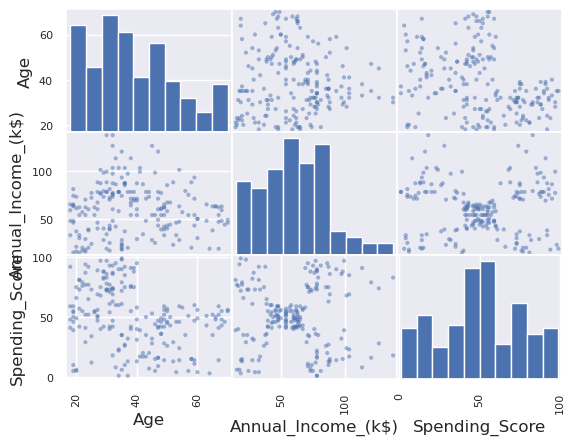

In [8]:
# scatter plot matrix
# Look for correlations!
scatter_matrix(dataset)
plt.show()

***
***
### Now let's access the data and get ready for clustering

In [9]:
#First set up your parameters
n_kmClusters=5 #Set Number of Clusters

# extract your data by the indices in the dataset:
# 0 = Gender
# 1 = Age
# 2 = Annual Income
# 3 = Spending Score
# This example obtains an array with Age, Income and Score.  Reduce/swap/reorder as desired.
Xmarket = dataset.iloc[:, [1,2,3]].values
#Xmarket = dataset.iloc[:, [2,3]].values #this version just grabs Income and Score

#check the shape of the data
print(Xmarket.shape)
#print(Xmarket)

(200, 3)


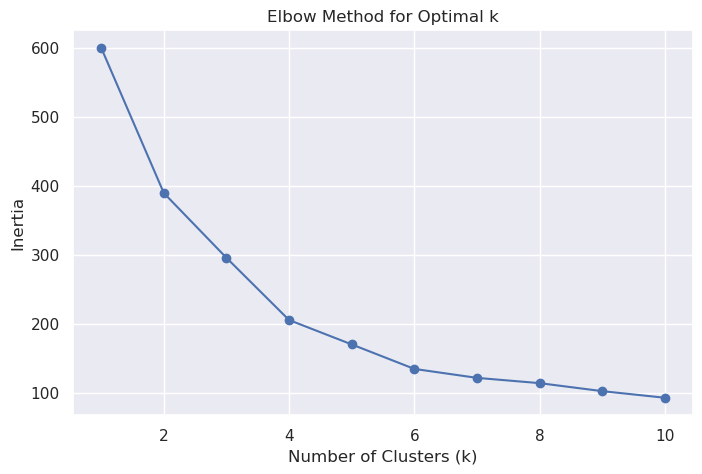

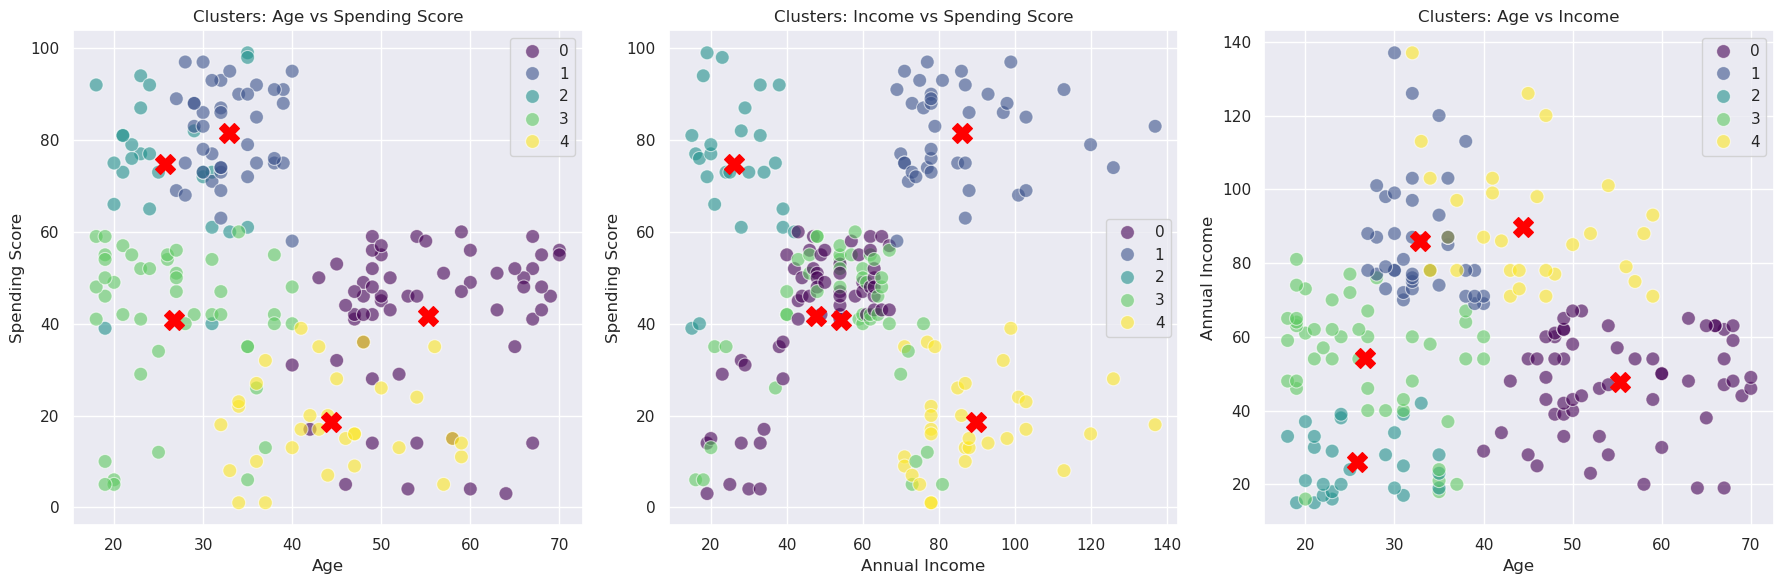


--- Clustering Summary ---
Selected Features: Age, Annual Income, Spending Score
Number of Clusters Chosen: 5
Cluster Centers (Age, Income, Spending Score):
 [[55.27586207 47.62068966 41.70689655]
 [32.875      86.1        81.525     ]
 [25.76923077 26.11538462 74.84615385]
 [26.73333333 54.31111111 40.91111111]
 [44.38709677 89.77419355 18.48387097]]


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the dataset
dataset = pd.read_csv('./Market_Customers.csv', index_col='CustomerID')

# Select features for clustering: Age, Annual Income, Spending Score
Xmarket = dataset.iloc[:, [1, 2, 3]].values  # Extracting Age, Income, and Spending Score

# Standardize the features (scaling helps K-Means perform better)
scaler = StandardScaler()
Xmarket_scaled = scaler.fit_transform(Xmarket)

# Finding the optimal number of clusters using the Elbow Method
inertia = []
K_range = range(1, 11)  # Checking k from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(Xmarket_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# From the elbow method, let's choose k=5 as the optimal number of clusters
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
labels = kmeans.fit_predict(Xmarket_scaled)

# Add the cluster labels to the original dataset
dataset['Cluster'] = labels

# Display cluster centers (in original feature scale)
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
#print("Cluster Centers (Age, Income, Spending Score):\n", cluster_centers)

# Create three separate plots for each feature
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Age vs Spending Score
sns.scatterplot(x=Xmarket[:, 0], y=Xmarket[:, 2], hue=labels, palette='viridis', s=100, alpha=0.6, ax=axes[0])
axes[0].scatter(cluster_centers[:, 0], cluster_centers[:, 2], c='red', marker='X', s=200, label='Centroids')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Spending Score')
axes[0].set_title('Clusters: Age vs Spending Score')

# Plot 2: Annual Income vs Spending Score
sns.scatterplot(x=Xmarket[:, 1], y=Xmarket[:, 2], hue=labels, palette='viridis', s=100, alpha=0.6, ax=axes[1])
axes[1].scatter(cluster_centers[:, 1], cluster_centers[:, 2], c='red', marker='X', s=200, label='Centroids')
axes[1].set_xlabel('Annual Income')
axes[1].set_ylabel('Spending Score')
axes[1].set_title('Clusters: Income vs Spending Score')

# Plot 3: Age vs Annual Income
sns.scatterplot(x=Xmarket[:, 0], y=Xmarket[:, 1], hue=labels, palette='viridis', s=100, alpha=0.6, ax=axes[2])
axes[2].scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='X', s=200, label='Centroids')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Annual Income')
axes[2].set_title('Clusters: Age vs Income')

plt.tight_layout()
plt.show()

# Print variables, number of clusters, and cluster centers
print("\n--- Clustering Summary ---")
print(f"Selected Features: Age, Annual Income, Spending Score")
print(f"Number of Clusters Chosen: {optimal_k}")
print("Cluster Centers (Age, Income, Spending Score):\n", cluster_centers)


### High-Level Analysis of the Clusters:

1. **Cluster 0: Younger, Low Income, Low Spending**
   - **Age**: Young
   - **Income**: Low
   - **Spending**: Low
   - **Explanation**: Likely students or early-career individuals with limited income and spending power.

2. **Cluster 1: Older, High Income, High Spending**
   - **Age**: Older
   - **Income**: High
   - **Spending**: High
   - **Explanation**: Individuals with higher incomes and greater discretionary spending, possibly professionals or retirees.

3. **Cluster 2: Middle-Aged, Moderate Income, Moderate Spending**
   - **Age**: Middle-aged
   - **Income**: Moderate
   - **Spending**: Moderate
   - **Explanation**: Working professionals with a balanced income and spending habits, managing family or household expenses.

4. **Cluster 3: Young, High Spending, Low Income**
   - **Age**: Young
   - **Income**: Low
   - **Spending**: High
   - **Explanation**: Young individuals spending beyond their income, possibly using credit or focusing on specific high-priority purchases.

5. **Cluster 4: Older, Low Income, Low Spending**
   - **Age**: Older
   - **Income**: Low
   - **Spending**: Low
   - **Explanation**: Retired or lower-income individuals with minimal discretionary spending.

### Conclusion:
The clusters effectively group customers based on **age, income, and spending behavior**, offering insights into targeted marketing strategies for different customer segments.
